In [1]:
print('Starting Imports')
import numpy as np
from scipy.special import gamma
# from MechanismsOneDimension import *
# from MechanismsStripped import *
import matplotlib.pyplot as plt
import sys
from time import time
import resource
import pandas as pd

print('Defining Isotope')
me = .511
gA = 1.254

Ms = ['MGT','MF','MGTW','MFW','MGTQ','MFQ','MT','MR','MP']
SeNME=dict.fromkeys(Ms)
SeNME['MGT'] = 3.003
SeNME['MF'] = -.606/(gA**2)
SeNME['MGTQ'] = 3.004
SeNME['MFQ'] = -0.487/(gA**2)
SeNME['MGTW'] = 2.835
SeNME['MFW'] = -.617/(gA**2)
SeNME['MT'] = 0.012
SeNME['MR']=3.252
SeNME['MP'] = .5*SeNME['MGT']

SeNME['A'] = 82
SeNME['Z'] = 36
SeNME['Sf']=92
SeNME['Qbb']=2.99512

Starting Imports
Defining Isotope


In [2]:
import numpy as np
from scipy.special import gamma
from scipy.integrate import trapz, quad, dblquad, simps

from cmath import sqrt,polar,exp,pi
from time import time
import os
import itertools
from scipy.stats import chisquare
import pandas as pd


me = .511



class bbMechanismsStats:
    def __init__(self,IsoDict, EtaLim, NuLim, LambdaLim, Phi, Phi2,bins):
        self.bins=bins
        self.me = .511
        self.gA = 1.254
        self.A = IsoDict['A']  # (number of nucleons)(temp value)
        self.Qbb = IsoDict['Qbb']  # Energy released in decay
        self.hbarc = 197.3269602
        self.R = self.me * 1.2 * (self.A ** (1 / 3)) / self.hbarc
        self.T = self.Qbb /self.me
        self.a = 1 / 137  # finestructure constant
        self.Z = IsoDict['Z']  # (number of protons? maybe?)
        self.Sf = IsoDict['Sf']  # (Screening factor) this will change for different elements
        self.Zs = self.Z * self.Sf / 100

        self.Gf = 1.1663787 * 10 ** -5  # Fermis Constant
        self.cosc = 0.9749  # Cabibo Angle

        self.phi1 = Phi
        self.phi2 = Phi2
        self.Etas = EtaLim
        self.Nus = NuLim
        self.Lambdas = LambdaLim

        self.ParamList =  list(itertools.product(*[self.Etas,self.Nus,self.Lambdas]))

        self.MGT = IsoDict['MGT']
        self.MF = IsoDict['MF']
        self.MGTW = IsoDict['MGTW']
        self.MFW = IsoDict['MFW']
        self.MGTQ = IsoDict['MGTQ']
        self.MFQ = IsoDict['MFQ']
        self.MT = IsoDict['MT']
        self.MR = IsoDict['MR']
        self.MP = IsoDict['MP']

        self.G1 = 2.31*10**(-14)

        # self a0v = (gA**4)*((Gf*cosc)**4)*(me**4)/(32*np.pi**

    def InitializeIsotope(self):

        self.CalcEpsilon()
        self.Calcg0()
        self.CalcXs()
        # self.CalcZs()


    def GetKineticDist(self):
        x = np.linspace(0,self.Qbb-.01,2996)
        y =[]
        for i in x:
            y.append(self.KineticDist(i/me))
        return x,y

    def GetAngularDist(self):
        x = np.linspace(0,pi,100)
        y = []
        for i in x:
            y.append(self.AngularDist(i))
        return x,y

    def GetAng(self):
        return self.Ang



    def AIFunc(self,i):
        x = i
        x2 = self.T+2-x
        AA = self.CalcAA(x,x2)

        return self.g0 * self.Calcw0v(x,x2) * AA / (self.R ** 2)

    def BIFunc(self,i):
        x = i
        x2 = self.T+2-x
        BB = self.CalcBB(x,x2)

        return self.g0 * self.Calcw0v(x,x2) * BB / (self.R ** 2)

    def AI(self):
        AI = quad(self.AIFunc, 1, self.T+1)
        return AI

    def BI(self):
        BI = quad(self.BIFunc, 1, self.T+1)
        return BI

    def AngularDist(self,theta):
        return (np.log(2)*10**24)*(self.AI()[0]+np.cos(theta)*self.BI()[0])/(2*pi)

    def Calcg0(self):
        self.g0 = 2.8 * (10 ** (-22)) * (self.gA ** 4)

    def Calcw0v(self,x,x2):

        return np.sqrt(x ** 2 - 1) * np.sqrt(x2 ** 2 - 1) * x * x2


    def CalcAA(self,x,x2):
        N1, N2, N3, N4 = self.CalcN(x,x2)
        return (polar(N1)[0]) ** 2 + (polar(N2)[0]) ** 2 + (polar(N3)[0]) ** 2 + (polar(N4)[0]) ** 2

    def CalcBB(self,x,x2):
        N1, N2, N3, N4 = self.CalcN(x,x2)
        return -2*np.real(np.conj(N1)*N2+np.conj(N3)*N4)

    def CalcN(self,x,x2):
        eps12 = self.CalcEps12(x,x2)
        Amm, Amp, Apm, App = self.CalcAs(x,x2)
        N1 = np.conj(Amm) * (
                    (self.Z1 - 4 * self.Z6 / 3) - (4 / self.R) * (self.Z4 - self.epsilon * self.Z6 / 6))
        N2 = np.conj(App) * (
                    (self.Z1 - 4 * self.Z6 / 3) + (4 / self.R) * (self.Z4 - self.epsilon * self.Z6 / 6))
        N3 = np.conj(Apm) * (
                    (self.Z1 - 2 * self.Z5 / 3) - eps12 * (self.Z3 + self.epsilon * self.Z5 / 3))
        N4 = np.conj(Amp) * (
                    (self.Z1 - 2 * self.Z5 / 3) + eps12 * (self.Z3 + self.epsilon * self.Z5 / 3))
        return N1, N2, N3, N4

    def CalcAs(self, x,x2):
        Am1,Am2,Ap1,Ap2 = self.CalcAmAp(x,x2)
        Amm = Am1 * Am2
        Amp = Am1 *Ap2
        Apm = Ap1 * Am2
        App = Ap1 * Ap2
        return Amm, Amp, Apm, App

    def CalcAmAp(self, x,x2):
        # x2 = self.CalcEps2(x)
        Am1 = sqrt((x + 1) / (2 * x)) * sqrt(self.F(x, 1))
        # print(x,x2)
        Am2 = sqrt((x2 + 1) / (2 * x2)) * sqrt(self.F(x2, 1))
        Ap1 = sqrt((x - 1) / (2 * x)) * sqrt(self.F(x, 1))
        Ap2 = sqrt((x2 - 1) / (2 * x2)) * sqrt(self.F(x2, 1))

        return (Am1,Am2,Ap1,Ap2)

    def CalcEps12(self, x,x2):
        return x - x2

    def CalcEpsilon(self):
        self.epsilon = 3 * self.a * self.Zs + (self.T + 2) * self.R

    def CalcP(self, x):
        return sqrt(x ** 2 - 1)

    def CalcEps2(self, x):
        return self.T+2-x

    def F(self, x, k):
        return ((gamma(2 * k + 1) / (gamma(k) * gamma(2 * self.gammak(k) + 1))) ** 2) * ((2 * self.CalcP(x) * self.R) ** (2 * self.gammak(k) - 2 * k)) * ((polar(gamma(self.gammak(k) + 1j * self.y(x)))[0]) ** 2) * exp(pi * self.y(x))

    def gammak(self, k):
        return k ** 2 - (self.a * self.Z) ** 2

    def y(self, x):
        return self.a * self.Zs * x / self.CalcP(x)

    def CalcZs(self):
        self.Z1 = self.Nu * (self.XF - 1) * self.MGT
        self.Z3 = self.MGT * ((-self.Lambda) * (self.XGTW - self.XFW) * exp(1j * self.phi1) + self.Eta * (
                    self.XGTW + self.XFW) * exp(1j * self.phi2))
        self.Z4 = self.Eta * self.XR * exp(1j * self.phi2) * self.MGT
        self.Z5 = (1 / 3) * (
                    self.Lambda * self.X1P * exp(1j * self.phi1) - self.Eta * self.X1M * exp(1j * self.phi2)) * self.MGT
        self.Z6 = self.Eta * self.XP * exp(1j * self.phi2) * self.MGT

    def CalcXs(self):
        self.XGTQ = self.MGTQ / self.MGT
        self.XGTW = self.MGTW / self.MGT
        self.XF = self.MF / self.MGT
        self.XFQ = self.MFQ / self.MGT
        self.XFW = self.MFW / self.MGT
        self.XT = self.MT / self.MGT
        self.XR = self.MR / self.MGT
        self.XP = self.MP / self.MGT

        self.X1P = (self.XGTQ + 3 * self.XFQ - 6 * self.XT)
        self.X1M = (self.XGTQ - 3 * self.XFQ - 6 * self.XT)
        self.X2P = (self.XGTW + self.XFW - self.X1P / 9)
        self.X2M = (self.XGTW - self.XFW - self.X1M / 9)

    def KineticDist(self,i):
        x = .5*(self.T + 2 + i)
        x2 = .5*(self.T+2-i)

        AA = self.CalcAA(x,x2)
        return np.log(2) * (10 ** 23) * self.g0 * self.Calcw0v(x,x2) * AA / (self.R ** 2)  ## 10**27

    def GetReverse(self,n=5000):
        en = np.linspace(0,self.Qbb-.00001,n)
        y=[0]
        for l in en[1:]:
            y.append(self.KineticDist(l/me))
        hl=simps(y,en)
        ysum = [np.sum(y[:lm])/np.sum(y) if lm>0 else 0 for lm in range(0,n)]

        return np.asarray(en),np.asarray(ysum)



In [11]:
from matplotlib import ticker
hl=np.load('../HalflivesLin50_V2.npy')
mmin=np.min(hl)
mmax=np.max(hl)
# sfmt=ticker.ScalarFormatter(useMathText=False) 
# sfmt.set_powerlimits((0, 0))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}


from matplotlib import rc
rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
Nu = [10**-12,10**-6.154902]
Eta = [10**-12,10**-8.154902]
Lambda = [10**-12,10**-6.154902]

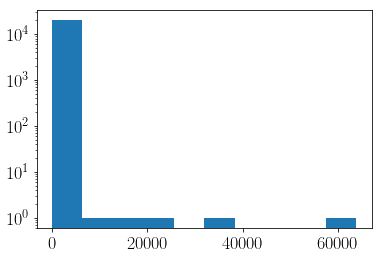

In [4]:
plt.figure()
plt.hist(np.random.choice(hl.flatten(), size=20000),log=True)
plt.show()

In [42]:
# hl=hl/(np.log(2)*10**2)
inds = [[]]
for l1 in range(0,50):
    for l2 in range(0,50):
        for l3 in range(0,50):
            if np.abs(hl[l1,l2,l3]-10)<2:
                inds.append([l1,l2,l3])
inds=inds[1:]
inds = inds[::2]
# inds=inds[:-1]
inds=inds[:200]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


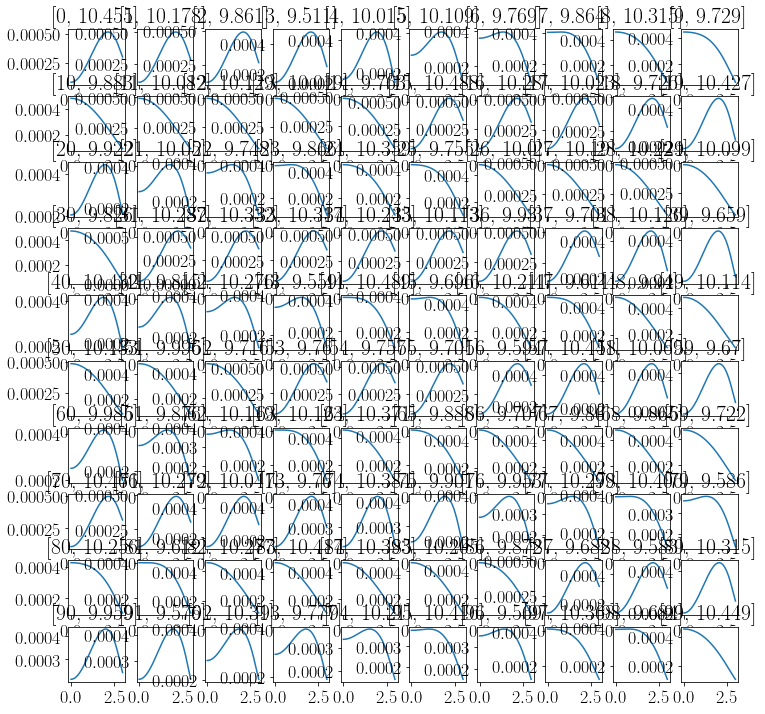

In [15]:
plt.figure(figsize=(12,12))
Nu = [10**-12,10**-6.154902]
Eta = [10**-12,10**-8.154902]
Lambda = [10**-12,10**-6.154902]
Nus = np.linspace(Nu[0],Nu[1],50)
Etas=np.linspace(Eta[0],Eta[1],50)
Lambdas=np.linspace(Lambda[0],Lambda[1],50)
Test = bbMechanismsStats(SeNME,Eta,Nu,Lambda,0,0,50)
Test.InitializeIsotope()
KeV={}
MeV={}


for i,config in enumerate(inds[:100]):
    print(i)
    Test.Eta=Etas[config[0]]
    Test.Nu=Nus[config[1]]
    Test.Lambda=Lambdas[config[2]]
    Test.CalcZs()
    if not os.path.exists(str(config[0])+'_'+str(config[1])+'_'+str(config[2])+'cdf.npy'):
            enInd, cInd = Test.GetReverse()
            cdf = np.stack([enInd,cInd],axis=1)
            np.save(str(config[0])+'_'+str(config[1])+'_'+str(config[2])+'cdf',cdf)
    x,y = Test.GetKineticDist()
    y = y/np.sum(y)
    KeV[i] = y
    MeV[i] = [np.sum(y[:1000]),np.sum(y[1000:2000]),np.sum(y[2000:])]
    
    plt.subplot(10,10,i+1)
    plt.title([i,round(hl[config[0],config[1],config[2]],3)])
    plt.plot(x,y)
plt.show()
# ind = [inds[0],inds[4],inds[18],inds[3]]

In [13]:
def GenerateSample(numberOfSamples,config,printing=False):

    samples = []
    numberofLoops =0

    cdf = np.load(str(config[0])+'_'+str(config[1])+'_'+str(config[2])+'cdf.npy')
    enInd, cInd = np.split(cdf,2,axis=1)

    while len(samples)<numberOfSamples:
        dart = np.random.uniform(0,1)
        ind = np.abs(cInd-dart).argmin()
        samples.append(int(enInd[ind][0]*1000))

    return samples


In [16]:
# del(DF)
samples = [5,20,100]
DictKeys=['TrueID','FakeID','Samples','llhkeV','llhMeV']
for i in range(3):
    config=[inds[32]]
    i1 = i
    print(i1,config)
    for i2 in samples:
        print(i2)
        for i3 in range(0,1000):
            if i3%200 ==0:
                print(100*i3/1000,'% Done with sample')
#             print(i3)
            data = GenerateSample(i2,config)
#             print([int((i5/1000))for i5 in data])
#             print(data)
            likelihoodskeV = []
            likelihoodsMeV =[]
        
            for i4 in range(0,len(inds)):
#                 print(i4)
                l1 = -1*np.sum([np.log(KeV[i4][int(round(i5))]) for i5 in data])
                l2 = -1*np.sum([np.log(MeV[i4][int((i5/1000))]) for i5 in data])
                likelihoodskeV.append(l1)
                likelihoodsMeV.append(l2)
#             print(likelihoodskeV)
            l1 = [item-np.min(likelihoodskeV) for item in likelihoodskeV] 
#             print(l1)
            l2 = [item-np.min(likelihoodsMeV) for item in likelihoodsMeV] 
            for i4 in range(0,len(inds)):
                tempDict= {'TrueID':[i1],'TestID':[i4],'Samples':[i2],'llhkeV':[l1[i4]],'llhMeV':[l2[i4]]}

                if 'DF' not in globals():
                    DF = pd.DataFrame(tempDict)
                else:
                    DF2 = pd.DataFrame(tempDict)
                    DF=DF.append(DF2)

          
            

0 [5, 5, 9]
5
0.0 % Done with sample


KeyError: 100

In [56]:
# FullDataFrame = DF
# FullDataFrame.to_pickle('ToyModelLikelihoods100V2.h5')
# FullDataFrame= pd.read_pickle('ToyModelLikelihoods100V2.h5')

KeV

{0: array([8.37190004e-05, 8.37192057e-05, 8.37198216e-05, ...,
        3.01621841e-04, 3.01297385e-04, 3.00972602e-04]),
 1: array([0.00010389, 0.00010389, 0.00010389, ..., 0.00028473, 0.0002844 ,
        0.00028408]),
 2: array([0.00012499, 0.00012499, 0.00012499, ..., 0.00026775, 0.00026743,
        0.0002671 ]),
 3: array([0.0001466 , 0.0001466 , 0.0001466 , ..., 0.00025098, 0.00025065,
        0.00025033]),
 4: array([0.00021498, 0.00021498, 0.00021498, ..., 0.00020111, 0.0002008 ,
        0.00020049]),
 5: array([0.00028833, 0.00028833, 0.00028833, ..., 0.00015224, 0.00015195,
        0.00015166]),
 6: array([0.00035741, 0.00035741, 0.00035741, ..., 0.00011064, 0.00011038,
        0.00011011]),
 7: array([4.02892863e-04, 4.02892872e-04, 4.02892897e-04, ...,
        8.62352804e-05, 8.59928371e-05, 8.57503166e-05]),
 8: array([4.64489634e-04, 4.64489600e-04, 4.64489499e-04, ...,
        6.00603698e-05, 5.98606073e-05, 5.96608364e-05]),
 9: array([4.41133266e-04, 4.41133248e-04, 4.4

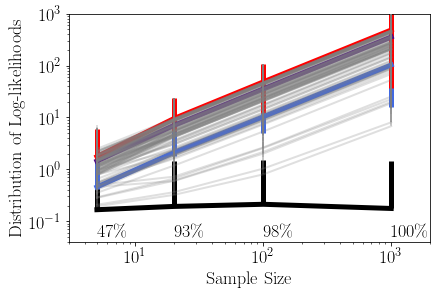

<Figure size 432x432 with 0 Axes>

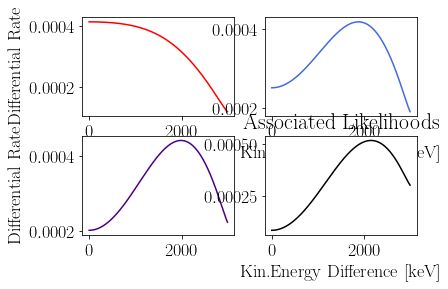

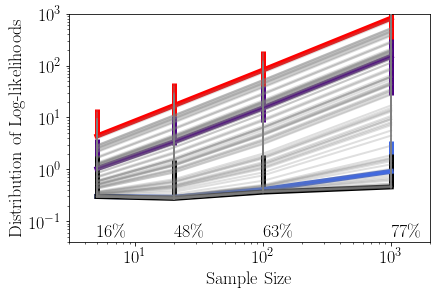

<Figure size 432x432 with 0 Axes>

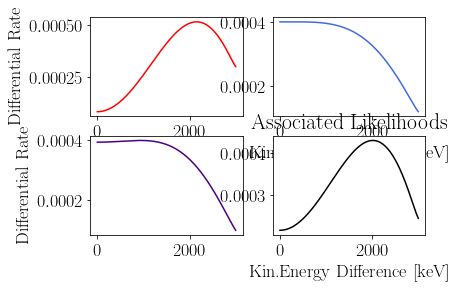

In [63]:
samples = [5,20,100,1000]
def LLAnalysiskeV(Dataframe,confignum,samples,inds):
    CutDF = Dataframe[Dataframe['TrueID']==confignum]
    ValskeV={}
    ValsMeV={}
    for l1 in samples:
        Cut2DF = CutDF[CutDF['Samples']==l1]
        for l2,item2 in enumerate(inds):
            ValskeV[str(l1)+','+str(l2)] = Cut2DF[Cut2DF['TestID']==l2]['llhkeV']
            ValsMeV[str(l1)+','+str(l2)] = Cut2DF[Cut2DF['TestID']==l2]['llhMeV']
#     plt.figure(figsize=(8,8))
    kevMeanDict={}
    MevMeanDict={}
    limkeV={}
    fig = plt.figure(constrained_layout=True,figsize=(6,4))
    gs = fig.add_gridspec(4, 4)
    f_ax1 = fig.add_subplot(gs[0:4, 0:4])
#     print(ValskeV.keys())
#     f_ax2 = fig.add_subplot(gs[0, -1])
# #     f3_ax2.set_title('gs[1, :-1]')
#     f_ax3 = fig.add_subplot(gs[1, -1])
# #     f3_ax3.set_title('gs[1:, -1]')
#     f_ax4 = fig.add_subplot(gs[2, -1])
# #     f3_ax4.set_title('gs[-1, 0]')
#     f_ax5 = fig.add_subplot(gs[3, -1])
# #     f3_ax5.set_title('gs[-1, -2]')
#     print(ValskeV['100,100'])
    for l2,item2 in enumerate(inds):
        kevMean=[]
        kevLow =[]
        kevHigh = []
        for l1 in samples:
#             print(str(l1)+','+str(l2))
            per = np.percentile(ValskeV[str(l1)+','+str(l2)],[5,50,95])
            kevMean.append(np.mean(ValskeV[str(l1)+','+str(l2)]))
            kevLow.append(per[0])
            kevHigh.append(per[2])
            kevMeanDict[str(l1)+','+str(l2)]=np.mean(ValskeV[str(l1)+','+str(l2)])
            if l2 ==confignum:
                limkeV[l1] = np.mean(ValskeV[str(l1)+','+str(l2)])+per[2]


#     print(kevMeanDict)
    for l1 in samples:
        tempCount = -1
        rank = []
        iters = []
        for l2 in range(0,len(inds)):
            if l1 == np.max(samples):
                rank.append(kevMeanDict[str(l1)+','+str(l2)])
                iters.append(l2)
            if kevMeanDict[str(l1)+','+str(l2)]<=limkeV[l1]:
                tempCount+=1
#         plt.text(l1,0,s=str(100*(1-tempCount/len(inds)))+'% Rej.')
        f_ax1.text(l1,0.05,s=str(round(100*(1-tempCount/(len(inds)))))+r'\%')
    
    
    sortL = [i for _,i in sorted(zip(rank,iters))]
    maxLiter = sortL[-1]
    midLiter = sortL[int(4*len(sortL)/6)]
    lowLiter = sortL[int(len(sortL)/6)]
    trueLiter = confignum
    for l2, item2 in enumerate(inds):
        kevMean=[]
        kevLow =[]
        kevHigh = []
        for l1 in samples:
            per = np.percentile(ValskeV[str(l1)+','+str(l2)],[5,50,95])
            kevMean.append(np.mean(ValskeV[str(l1)+','+str(l2)]))
            kevLow.append(per[0])
            kevHigh.append(per[2])
            kevMeanDict[str(l1)+','+str(l2)]=np.mean(ValskeV[str(l1)+','+str(l2)])
            if l2 ==confignum:
                limkeV[l1] = np.mean(ValskeV[str(l1)+','+str(l2)])+per[2]
        if l2 == confignum or l2== maxLiter or l2==midLiter or l2==lowLiter:
            if l2 == confignum:
                label='True Param'
                co = 'k'
            elif l2 == maxLiter:
                label='High LLH'
                co='red'
            elif l2 == midLiter:
                label='Middle LLH'
                co='indigo'
            elif l2 == lowLiter:
                label='Low LLH'
                co='royalblue'
            f_ax1.errorbar(samples,kevMean,yerr=np.row_stack((kevLow, kevHigh)),lw=5,zorder=0,c=co,label=label)
#             limkeV = [kevMean[i]+kevHigh[i] for i in range(0,len(kevMean))]
        else:
            f_ax1.errorbar(samples,kevMean,yerr=np.row_stack((kevLow, kevHigh)),lw=2,alpha = .25,zorder=5,c='gray')
        
    f_ax1.set_ylim([.04,10**3])
    f_ax1.set_xlim([3,2000])

#     f_ax1.legend()
    f_ax1.set_xscale('log')
    f_ax1.set_yscale('log')
    f_ax1.set_xlabel('Sample Size')
    f_ax1.set_ylabel('Distribution of Log-likelihoods')

    
#     fig.show()
    plt.savefig('keVResolutionRejection_Ind'+str(confignum)+'.png')
    
    plt.figure(figsize=(6,6))
    f, axs = plt.subplots(2, 2)
    f_ax2 = axs[0,0]
    f_ax3 = axs[1,0]
    f_ax4 = axs[0,1]

    f_ax5 = axs[1,1]


    f_ax2.plot([i for i in range(0,2996)],KeV[maxLiter],c='red')
    f_ax2.set_ylabel('Differential Rate')
#     f_ax2.set_xticks([])
#     f_ax2.set_yticks([])
    f_ax3.plot([i for i in range(0,2996)],KeV[midLiter],c='indigo')
    f_ax3.set_ylabel('Differential Rate')

#     f_ax3.set_xticks([])
#     f_ax3.set_yticks([])
    f_ax4.plot([i for i in range(0,2996)],KeV[lowLiter],c='royalblue')
#     f_ax4.set_xticks([])
#     f_ax4.set_yticks([])
    f_ax5.plot([i for i in range(0,2996)],KeV[trueLiter],c='k')

#     f_ax5.set_xticks([])
#     f_ax5.set_yticks([])
    f_ax5.set_xlabel('Kin.Energy Difference [keV]')
    f_ax4.set_xlabel('Kin.Energy Difference [keV]')

    plt.title('Associated Likelihoods')
    plt.savefig('AsscLike.png')



LLAnalysiskeV(FullDataFrame,0,samples,inds[:99])
# LLAnalysiskeV(FullDataFrame,46,samples,inds)
# LLAnalysiskeV(FullDataFrame,53,samples,inds)
LLAnalysiskeV(FullDataFrame,90,samples,inds[:99])


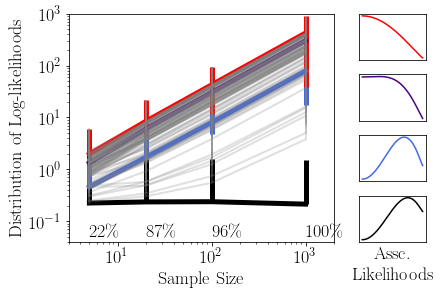

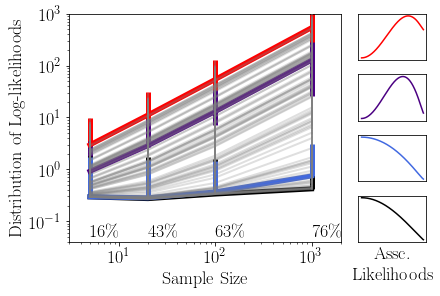

In [196]:
samples = [5,20,100,1000]
def LLAnalysisMeV(Dataframe,confignum,samples,inds):
    CutDF = Dataframe[Dataframe['TrueID']==confignum]
#     ValskeV={}
    ValsMeV={}
    for l1 in samples:
        Cut2DF = CutDF[CutDF['Samples']==l1]
        for l2,item2 in enumerate(inds):
#             ValskeV[str(l1)+','+str(l2)] = Cut2DF[Cut2DF['TestID']==l2]['llhkeV']
            ValsMeV[str(l1)+','+str(l2)] = Cut2DF[Cut2DF['TestID']==l2]['llhMeV']
#     plt.figure(figsize=(8,8))
#     kevMeanDict={}
    MevMeanDict={}
    limMeV={}
    fig = plt.figure(constrained_layout=True,figsize=(6,4))
    gs = fig.add_gridspec(4, 5)
    f_ax1 = fig.add_subplot(gs[0:4, 0:4])

    f_ax2 = fig.add_subplot(gs[0, -1])
#     f3_ax2.set_title('gs[1, :-1]')
    f_ax3 = fig.add_subplot(gs[1, -1])
#     f3_ax3.set_title('gs[1:, -1]')
    f_ax4 = fig.add_subplot(gs[2, -1])
#     f3_ax4.set_title('gs[-1, 0]')
    f_ax5 = fig.add_subplot(gs[3, -1])
#     f3_ax5.set_title('gs[-1, -2]')
    
    for l2,item2 in enumerate(inds):
        MevMean=[]
        MevLow =[]
        MevHigh = []
        for l1 in samples:
            per = np.percentile(ValsMeV[str(l1)+','+str(l2)],[5,50,95])
            MevMean.append(np.mean(ValsMeV[str(l1)+','+str(l2)]))
            MevLow.append(per[0])
            MevHigh.append(per[2])
            MevMeanDict[str(l1)+','+str(l2)]=np.mean(ValsMeV[str(l1)+','+str(l2)])
            if l2 ==confignum:
                limMeV[l1] = np.mean(ValsMeV[str(l1)+','+str(l2)])+per[2]


#     print(kevMeanDict)
    for l1 in samples:
        tempCount = -1
        rank = []
        iters = []
        for l2 in range(0,len(inds)):
            if l1 == np.max(samples):
                rank.append(MevMeanDict[str(l1)+','+str(l2)])
                iters.append(l2)
            if MevMeanDict[str(l1)+','+str(l2)]<=limMeV[l1]:
                tempCount+=1
#         plt.text(l1,0,s=str(100*(1-tempCount/len(inds)))+'% Rej.')
        f_ax1.text(l1,0.05,s=str(round(100*(1-tempCount/(len(inds)))))+r'\%')
    
    
    sortL = [i for _,i in sorted(zip(rank,iters))]
    maxLiter = sortL[-1]
    midLiter = sortL[int(4*len(sortL)/6)]
    lowLiter = sortL[int(len(sortL)/6)]
    trueLiter = confignum
    for l2, item2 in enumerate(inds):
        MevMean=[]
        MevLow =[]
        MevHigh = []
        for l1 in samples:
            per = np.percentile(ValsMeV[str(l1)+','+str(l2)],[5,50,95])
            MevMean.append(np.mean(ValsMeV[str(l1)+','+str(l2)]))
            MevLow.append(per[0])
            MevHigh.append(per[2])
            MevMeanDict[str(l1)+','+str(l2)]=np.mean(ValsMeV[str(l1)+','+str(l2)])
            if l2 ==confignum:
                limMeV[l1] = np.mean(ValsMeV[str(l1)+','+str(l2)])+per[2]
        if l2 == confignum or l2== maxLiter or l2==midLiter or l2==lowLiter:
            if l2 == confignum:
                label='True Param'
                co = 'k'
            elif l2 == maxLiter:
                label='High LLH'
                co='red'
            elif l2 == midLiter:
                label='Middle LLH'
                co='indigo'
            elif l2 == lowLiter:
                label='Low LLH'
                co='royalblue'
            f_ax1.errorbar(samples,MevMean,yerr=np.row_stack((MevLow, MevHigh)),lw=5,zorder=0,c=co,label=label)
#             limkeV = [kevMean[i]+kevHigh[i] for i in range(0,len(kevMean))]
        else:
            f_ax1.errorbar(samples,MevMean,yerr=np.row_stack((MevLow, MevHigh)),lw=2,alpha = .25,zorder=50,c='gray')
        
    f_ax1.set_ylim([.04,10**3])
    f_ax1.set_xlim([3,2000])

#     f_ax1.legend()
    f_ax1.set_xscale('log')
    f_ax1.set_yscale('log')
    f_ax1.set_xlabel('Sample Size')
    f_ax1.set_ylabel('Distribution of Log-likelihoods')
    
    f_ax2.plot([i for i in range(0,2996)],KeV[maxLiter],c='red')
    f_ax2.set_xticks([])
    f_ax2.set_yticks([])
    f_ax3.plot([i for i in range(0,2996)],KeV[midLiter],c='indigo')
    f_ax3.set_xticks([])
    f_ax3.set_yticks([])
    f_ax4.plot([i for i in range(0,2996)],KeV[lowLiter],c='royalblue')
    f_ax4.set_xticks([])
    f_ax4.set_yticks([])
    f_ax5.plot([i for i in range(0,2996)],KeV[trueLiter],c='k')

    f_ax5.set_xticks([])
    f_ax5.set_yticks([])
    f_ax5.set_xlabel('Assc. \n Likelihoods')

    plt.savefig('MeVResolutionRejection_Ind'+str(confignum)+'.png')


LLAnalysisMeV(FullDataFrame,0,samples,inds)
# LLAnalysisMeV(FullDataFrame,46,samples,inds)
# LLAnalysisMeV(FullDataFrame,53,samples,inds)
LLAnalysisMeV(FullDataFrame,90,samples,inds)

In [40]:
# hls = np.linspace(1,1000,10000)
# samples = [10,100,1000,5000]
def TGen(hl,numberOfSamples):
    darts = np.random.rand(1,numberOfSamples)
    darts = np.reshape(darts,(darts.shape[1]))
    tsamples = -1*np.log(1-darts)    

    return hl*tsamples

# TS={}
# HLiter=992
# HL=hls[HLiter]
# print(HL)

# per=[68,95,99]
# for s in samples:
#     print('Running Simulations for '+str(s)+' Sample Sizes')
#     ts=[]
#     for iiters in range(0,500):
#         data = TGen(HL,s)
#         ltemp=np.zeros_like(hls)
#         for i in data:
#             ltemp=ltemp-np.log(np.exp(-(i-.01)/hls)-np.exp(-(i+.01)/hls))
#         ts.append(ltemp[HLiter]-np.min(ltemp))
#     tsper = np.percentile(ts,per)
#     for piter,p in enumerate(per):
#         TS[str(s)+','+str(p)]=tsper[piter]
        
Lims = {}
for s in samples:
    tempLow=[]
    tempHigh=[]
    print('Calculating Upper and Lower bound for '+str(s)+' Sample Sizes')
    for iiters in range(0,500):
        data = TGen(HL,s)
        ltemp=np.zeros_like(hls)
        for i in data:
            ltemp=ltemp-np.log(np.exp(-(i-.01)/hls)-np.exp(-(i+.01)/hls))
        ltemp = ltemp-np.min(ltemp)
        leftlim = [ n for n,i in enumerate(ltemp) if i<TS[str(s)+','+str(95)]][0]
#         print(leftlim)
        rlim = [ n for n,i in enumerate(ltemp[::-1]) if i<TS[str(s)+','+str(95)]][0]
        rightlim = len(ltemp)-1-rlim
        tempLow.append(hls[int(leftlim)])
        tempHigh.append(hls[int(rightlim)])
    Lims[str(s)+',L'] = np.percentile(tempLow,[5,50,95])
    Lims[str(s)+',H'] = np.percentile(tempHigh,[5,50,95])
        
        

Lims

        
        

100.1107110711071
Running Simulations for 10 Sample Sizes


/home/kelly/Desktop/MechEnv/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


Running Simulations for 100 Sample Sizes
Running Simulations for 1000 Sample Sizes
Running Simulations for 5000 Sample Sizes
Calculating Upper and Lower bound for 10 Sample Sizes


/home/kelly/Desktop/MechEnv/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


Calculating Upper and Lower bound for 100 Sample Sizes
Calculating Upper and Lower bound for 1000 Sample Sizes
Calculating Upper and Lower bound for 5000 Sample Sizes


{'10,H': array([108.45319532, 189.13051305, 305.38577858]),
 '10,L': array([33.05612061, 57.54905491, 92.93217822]),
 '100,H': array([103.36777678, 122.74032403, 141.78316832]),
 '100,L': array([69.51327633, 82.52655266, 95.320027  ]),
 '1000,H': array([101.20972097, 106.5049505 , 112.80427543]),
 '1000,L': array([ 90.01480648,  94.61566157, 100.31053105]),
 '5000,H': array([100.20562556, 102.60846085, 105.10621062]),
 '5000,L': array([ 95.41494149,  97.81278128, 100.11071107])}

In [185]:

Lims

{'10,H': array([ 46.73879388,  79.8289829 , 129.91386139]),
 '10,L': array([12.98420342, 22.0810081 , 35.97349235]),
 '1000,H': array([41.16381638, 43.46174617, 45.85958596]),
 '1000,L': array([36.5679568 , 38.56615662, 40.76417642]),
 '20,H': array([44.86048605, 65.74167417, 94.51575158]),
 '20,L': array([18.18451845, 26.5769577 , 38.16651665]),
 '5,H': array([ 47.35324032, 111.05085509, 214.02308731]),
 '5,L': array([ 7.79387939, 18.28442844, 35.16921692]),
 '50,H': array([42.16291629, 53.75247525, 68.13951395]),
 '50,L': array([24.57875788, 31.27272727, 39.57025203])}

In [186]:
HL

40.96399639963996

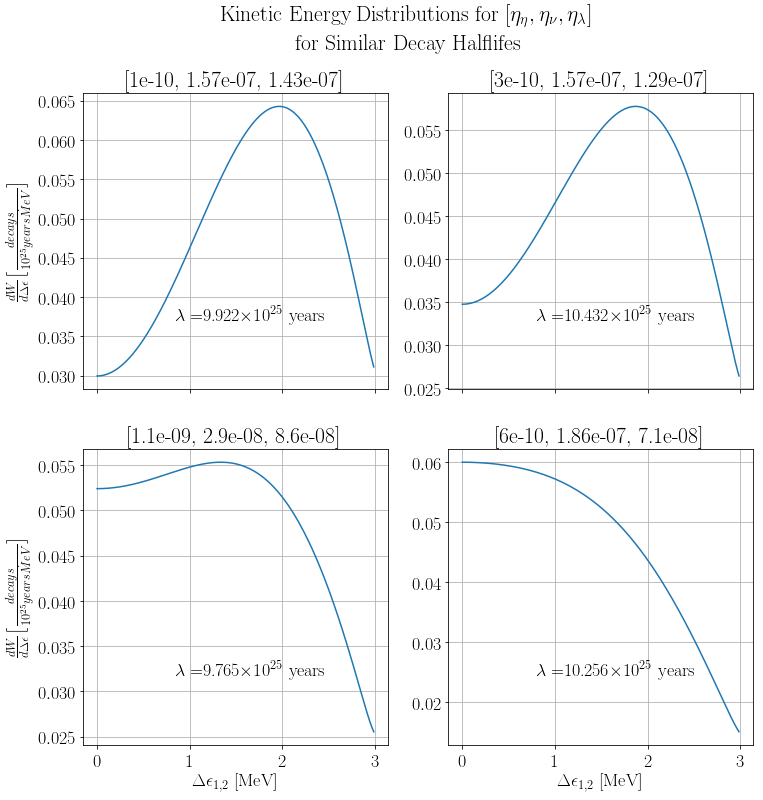

In [30]:
ind = [inds[1],inds[2],inds[7],inds[4]]
Test = bbMechanismsStats(SeNME,Eta,Nu,Lambda,0,0,50)
Test.InitializeIsotope()
plt.figure(figsize=(12,12))
for i,item in enumerate(ind):
    Test.Eta=Etas[item[0]]
    Test.Nu=Nus[item[1]]
    Test.Lambda=Lambdas[item[2]]
    Test.CalcZs()
    x,y = Test.GetKineticDist()
    y= np.asarray(y)*100
    ax= plt.subplot(2,2,i+1)
    titlea = [round(Etas[item[0]],10),round(Nus[item[1]],9),round(Lambdas[item[2]],9)]
    ax.set_title(titlea)
    ax.plot(x,y)
    ax.grid()
    ax.set_xticks([0,1,2,3])
    if i <=1:
        ax.set_xticklabels([])
    if i%2==0:
        ax.set_ylabel(r'$\frac{dW}{d\Delta \epsilon} \biggl [ \frac{decays}{10^{25}years\dot MeV}\biggr ] $ ')
    ax.text(.55,.25,r'$\lambda =$'+str(round(hl[item[0],item[1],item[2]],3))+r'$\times 10^{25}$ years',ha='center', va='center', transform=ax.transAxes)

    if i>=2:
        ax.set_xlabel(r'$\Delta \epsilon_{1,2}$ [MeV]')
    plt.suptitle(r'Kinetic Energy Distributions for [$ \eta _{\eta}, \eta _{\nu},\eta _{\lambda} $]'+'\n for Similar Decay Halflifes')

plt.savefig('KineticEnergyDistribution.png')

In [ ]:
plt.figure(figsize=(10,10))
Nu = [10**-12,10**-6.154902]
Eta = [10**-12,10**-8.154902]
Lambda = [10**-12,10**-6.154902]
Nus = np.linspace(Nu[0],Nu[1],50)
Etas=np.linspace(Eta[0],Eta[1],50)
Lambdas=np.linspace(Lambda[0],Lambda[1],50)
Test = bbMechanismsStats(SeNME,Eta,Nu,Lambda,0,0,50)
Test.InitializeIsotope()
for i,item in enumerate(inds):
    Test.Eta=Etas[item[0]]
    Test.Nu=Nus[item[1]]
    Test.Lambda=Lambdas[item[2]]
    Test.CalcZs()
    x,y = Test.GetAngularDist()
    plt.subplot(5,5,i+1)
    plt.title([i,item])
    plt.plot(x,y)
plt.show()
# ind = [inds[0],inds[4],inds[18],inds[3]]

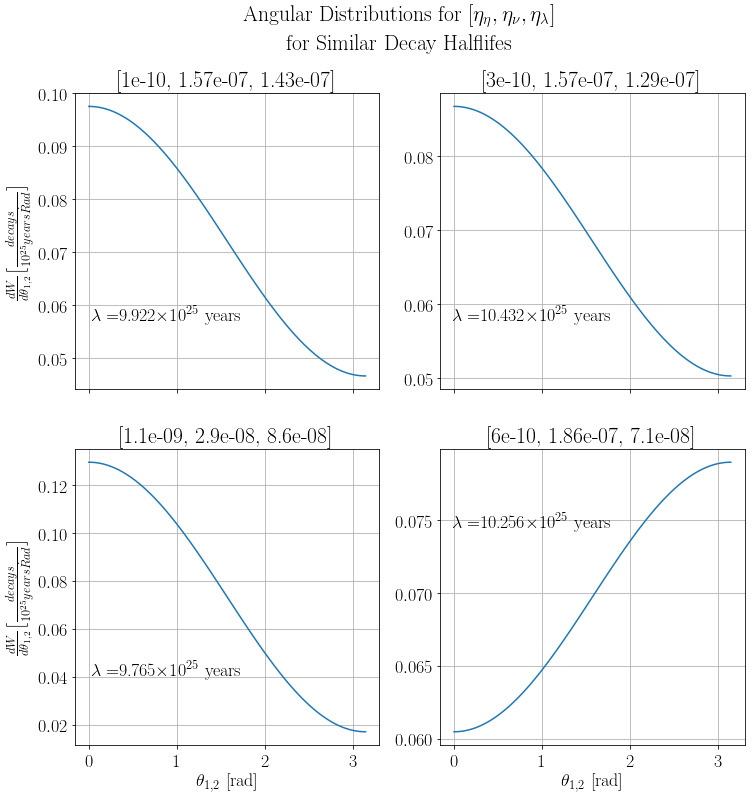

In [33]:
ind = [inds[1],inds[2],inds[7],inds[4]]
Test = bbMechanismsStats(SeNME,Eta,Nu,Lambda,0,0,50)
Test.InitializeIsotope()
plt.figure(figsize=(12,12))
for i,item in enumerate(ind):
    Test.Eta=Etas[item[0]]
    Test.Nu=Nus[item[1]]
    Test.Lambda=Lambdas[item[2]]
    Test.CalcZs()
    x,y = Test.GetAngularDist()
    ax= plt.subplot(2,2,i+1)
    titlea = [round(Etas[item[0]],10),round(Nus[item[1]],9),round(Lambdas[item[2]],9)]
    ax.set_title(titlea)
    ax.plot(x,[iy*50/(np.pi) for iy in y])
    ax.grid()
    ax.set_xticks([0,1,2,3])
    if i <=1:
        ax.set_xticklabels([])
    if i%2==0:
        ax.set_ylabel(r'$\frac{dW}{d\theta_{1,2}} \biggl [ \frac{decays}{10^{25}years\dot Rad}\biggr ] $ ')
    if i<3:
        ax.text(.3,.25,r'$\lambda =$'+str(round(hl[item[0],item[1],item[2]],3))+r'$\times 10^{25}$ years',ha='center', va='center', transform=ax.transAxes)
    elif i==3:
        ax.text(.3,.75,r'$\lambda =$'+str(round(hl[item[0],item[1],item[2]],3))+r'$\times 10^{25}$ years',ha='center', va='center', transform=ax.transAxes)

        
        plt.suptitle(r'Angular Distributions for [$ \eta _{\eta}, \eta _{\nu},\eta _{\lambda} $]'+'\n for Similar Decay Halflifes')
    if i>=2:
        ax.set_xlabel(r'$\theta_{1,2}$ [rad]')
        
plt.savefig('AngularDistribution.png')

True